# Библиотеки

In [1]:
import numpy as np
from numpy import linalg as LA
import pandas as pd
import csv
import os
from math import *

from scipy import interpolate
from scipy.integrate import quad
from scipy.stats import beta
from scipy.optimize import leastsq, curve_fit

from sklearn.linear_model import LinearRegression
from iminuit import Minuit
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

# Все для графиков
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in' 
plt.rcParams['figure.figsize']=(8,4)

plt.rcParams['xtick.major.size']=10
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.width'] = 1
# plt.rcParams['xtick.minor.visible'] = 'True'

plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.width'] = 1

plt.rcParams.update({'font.size':14})
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rcParams['axes.titlepad'] = 18

import Path_to_data

glob_add_name=Path_to_data.glob_add_name
optimization=Path_to_data.optimization  # 'off' or 'on'
best_ia, best_ib = Path_to_data.best_ia, Path_to_data.best_ib
best_ja, best_jb = Path_to_data.best_ja, Path_to_data.best_jb
result_average_mass=Path_to_data.result_average_mass  # 'off' or 'on'
N_all=Path_to_data.N_all

model_atmosphere=Path_to_data.model_atmosphere
Energy_CR= Path_to_data.Energy_CR
Angle_CR=Path_to_data.Angle_CR
Type_particles_CR=Path_to_data.Type_particles_CR
h = Path_to_data.h
r1,r2,r3 = Path_to_data.r1, Path_to_data.r2, Path_to_data.r3

# Директории взятия данных:
direct_mosaic_hits=Path_to_data.direct_mosaic_hits
direct_aberration=Path_to_data.direct_aberration
direct_coord=Path_to_data.direct_coord
direct_bg=Path_to_data.direct_bg


print('model_atmosphere = ', model_atmosphere, '\nEnergy_CR = ', Energy_CR,'PeV\nAngle_CR  = ',
      Angle_CR,'\nh  = ',h,'m\nType_particles_CR  = ', Type_particles_CR,'\n')

def f_name():
    f_name='{}_{}_{}PeV_{}_{}m_{}.txt'.format(model_atmosphere,model_interaction,Energy_CR,Angle_CR,h,Type_particle_CR)
    return f_name

df_data_list=[]
n_type=len(Type_particles_CR)  # Число первичных частиц
for i in range(n_type*2):
    Type_particle_CR=Type_particles_CR[i-n_type]   
    if i<n_type: model_interaction='q1'
    else:        model_interaction='q2'
    
    direct_in=Path.cwd()/'Sphere-2_result'/'appro_param_with_bg'/model_atmosphere/model_interaction/'{}PeV'.format(Energy_CR)/Angle_CR/'{}m'.format(h)
    file_in=direct_in/Path('param_bg_'+f_name())

    p = ((((pd.read_csv(file_in,header=0,sep=',')).dropna()).iloc[:,1:]))
    # Ограничение на радиус, в котором находится пик ФПР и отброс событий с неудавшейся аппроксимацией
    rhomax = 170  # мм -- радиус, в котором находится пик ФПР
    p2 = p[ ((p['x0']**2+p['y0']**2)**(1./2)<rhomax) & (p['fcn']<10000) ]
    print('Number of events ', Type_particle_CR, len(p2['p1']))
    p2.index = np.arange(len(p2['p0']))
    
    df_data_list.append(p2)

key=[j for j in range(n_type*2)]
df_together = pd.concat(df_data_list,keys=key)

N_samples=len(df_together.index.levels[0])  # or n_type*2
print('N_samples ', N_samples)

model_atmosphere =  m01 
Energy_CR =  10 PeV
Angle_CR  =  10-20 
h  =  900 m
Type_particles_CR  =  ['p', 'He', 'N', 'S', 'Fe'] 

Number of events  p 1681
Number of events  He 2496
Number of events  N 1639
Number of events  S 2499
Number of events  Fe 1560
Number of events  p 1677
Number of events  He 1716
Number of events  N 1642
Number of events  S 1629
Number of events  Fe 1616
N_samples  10


# Функции

In [2]:
def criterion(df,r1,r2,r3): 
    N_samples=len(df.index.levels[0])
    aver_infunc,aver2_infunc=np.zeros(N_samples),np.zeros(N_samples)
    s1,s2,s3=0,0,0
    cri_infunc,cri2_infunc=[],[]
    for i in range(N_samples): 
        L=len(df['p0'][i])
        cri_j,cri2_j=np.zeros(L),np.zeros(L)
        for j in range(L):
            a0,a1,a2,a3,a4,a5=df['p0'][i,j],df['p1'][i,j],df['p2'][i,j],df['p3'][i,j],df['p4'][i,j],df['s'][i,j]

            s1 = quad(integrand, 0, r1, args=(a0,a1,a2,a3,a4,a5))
            s2 = quad(integrand, 0, r2, args=(a0,a1,a2,a3,a4,a5))
            s3 = quad(integrand, r2, r3, args=(a0,a1,a2,a3,a4,a5))
            cri_j[j]=s2[0] /s3[0]
            cri2_j[j]=s1[0] /s3[0]
            
        aver2_infunc[i]=sum(cri2_j)/L    
        cri2_infunc.append(cri2_j)    
        aver_infunc[i]=sum(cri_j)/L
        cri_infunc.append(cri_j)
    return(aver_infunc,cri_infunc,aver2_infunc,cri2_infunc)

#===============================================================================
def sep_two(cri):
    pn_max_mi,pn_deltami,nf_max_mi,nf_deltami=100000,100000,100000,100000
    bpn_min=-0.2 
    bpn_max=1.2 
    N=100
    Nn=(bpn_max-bpn_min)/N
    for bpn in np.arange(bpn_min,bpn_max,Nn):
        
        pn_p=np.count_nonzero(cri[0]>bpn)/float(len(cri[0]))
        pn_n=np.count_nonzero(cri[1]<bpn)/float(len(cri[1]))  
        
        # 1 способ поиска min ошибки. Min(max)
        pn_max=max(pn_p,pn_n)
        if pn_max<pn_max_mi:
            pn_max_mi=pn_max
            pn_border_max=bpn
            #print(bpn,pn_max_mi,pn_p,pn_n)
            er_pn_max=[round(pn_p,3),round(pn_n,3)]           
    return [round(pn_max_mi,3),round(pn_border_max,3)]


'''
def sep_two(cri,cri_q2):
    pn_max_mi,nf_max_mi=100000,100000
    bpn_min=-0. #aver[1]
    bpn_max=1. #aver[0]
    N=100
    Nn=(bpn_max-bpn_min)/N
    for bpn in np.arange(bpn_min,bpn_max,Nn):
        
        pn_p=np.count_nonzero(cri[0]>bpn)/float(len(cri[0]))
        pn_n=np.count_nonzero(cri[1]<bpn)/float(len(cri[1]))  
        pn_p2=np.count_nonzero(cri_q2[0]>bpn)/float(len(cri_q2[0])) # !
        pn_n2=np.count_nonzero(cri_q2[1]<bpn)/float(len(cri_q2[1]))   #!

        pn_max=max(pn_p,pn_n,pn_p2,pn_n2)
        if pn_max<pn_max_mi:
            pn_max_mi=pn_max
            pn_border_max=bpn
            
            #print(bpn,pn_max_mi,pn_p,pn_n)
            er_pn_max=[round(pn_p,3),round(pn_n,3)]           
    return [round(pn_max_mi,3),round(pn_border_max,3)]
'''

#===============================================================================
def integrand(r,p0,p1,p2,p3,p4,s):
    return 2.0*pi*p0**2*r/(((1+p1*r+p2*r**2+p3*r**(1.5))**2)*(1+p4*r**s))

# разделение для любых заданных ядер
def bias_class_general(aver,aver2,cri,cri2,core1,core2):  # core1=0 - это протон, core2=1 - это азот, core3=2 - это железо
    if np.any(cri[core1]==cri2[core1]) or np.any(cri[1]==cri2[1]):
        return False
    else:
        m1=np.array([[aver[core1]],[aver2[core1]]])
        m2=np.array([[aver[core2]],[aver2[core2]]])        
        c1=(np.cov(cri[core1],cri2[core1]))  # ковариация протонов
        c2=(np.cov(cri[core2],cri2[core2]))   # ковариация азота
        c1_inv=LA.inv(c1)
        c2_inv=LA.inv(c2)
        bias3=np.log(np.linalg.det(c1)/np.linalg.det(c2))


        bias=[]
        for i in range(core1,core2+1):
            bias1,bias2,bias_res=np.zeros(len(cri[i])),np.zeros(len(cri[i])),np.zeros(len(cri[i]))
            for j in range(len(cri[i])):
                x=np.array([[cri[i][j]],[cri2[i][j]]])
                bias1[j]=np.dot(np.dot((x-m1).T,c1_inv),(x-m1))
                bias2[j]=np.dot(np.dot((x-m2).T,c2_inv),(x-m2))
                bias_res[j]=1/2*(float(bias1[j])-float(bias2[j])+bias3)
            bias.append(bias_res)
        return bias

# Расчет ошибок разделения при определенном r1,r2,r3 2D критерий

In [3]:
# r1,r2,r3=80,110,170 
out_f_one=pd.DataFrame(index=np.arange(1),columns=['pN_err','pn_border','nf_err','nf_border','r1','r2','r3'])

aver,cri,aver2,cri2=criterion(df_together,r1,r2,r3)

bias_cri=bias_class_general(aver,aver2,cri,cri2,0,2)   # cri[0] and cri[1]
bias_cri_Fe=bias_class_general(aver,aver2,cri,cri2,2,4)   # cri[1] and cri[2]

res_border_pN=sep_two(bias_cri)
res_border_NFe=sep_two(bias_cri_Fe)

out_f_one.loc[0]=np.concatenate([res_border_pN,res_border_NFe,[r1,r2,r3]])
out_f_one

,pN_err,pn_border,nf_err,nf_border,r1,r2,r3
0,0.439,0.472,0.443,0.22,80.0,110.0,170.0


# Регрессия от двумерного признакового пространства к массовому числу 

## Задание радиуса

In [4]:
# r1,r2,r3=80,110,170

aver,cri,aver2,cri2=criterion(df_together,r1,r2,r3)

# r=cri   # Если критерий одномерный
r=(np.asarray(cri,dtype='object')**2+np.asarray(cri2,dtype='object')**2)**(1./2)   # Если критерий двумерный


## Записываю массы p, N, Fe

Минимальный Rc --  2.508043575233609 
Максимальный Rc --  69.44457891772304
Максимальный Rc --  8.403928187098382


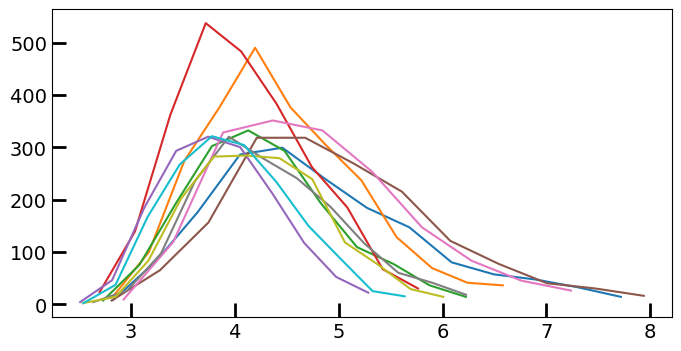

In [5]:
mass_toFe=[1.0078,4.0026,6.941,9.01218,10.81,12.011,14.0067,15.999,18.9984, \
           20.179,22.989,24.305,26.98,27.98,30.97376,32.064,35.453,39.948,39.0983,40.08, \
           44.956,47.9,50.942,51.99,54.938,55.847]
mass_name=['p','He','Li','Be','B','C','N','O','F','Ne','Na','Mg','Al','Si','P','S', \
           'Cl','Ar','K','Ca','Sc','Ti','V','Cr','Mn','Fe']

mass_dict=dict(zip(mass_name,mass_toFe))


mass_true,m_name,m_sort,color_two,color_sort=[],[],[],[],[]
c_two=['blue','orange']
Type_particles_sort=sorted(Type_particles_CR*2)


for i in range(N_samples):
    Type_particle_CR=Type_particles_CR[i-len(Type_particles_CR)]
    
    if i<len(Type_particles_CR): 
        model_interaction='q1'
        color_two.append('blue')   
    else:                       
        model_interaction='q2'
        color_two.append('orange') 
        
    mass_true.append(mass_dict[Type_particle_CR])
    m_name.append(Type_particle_CR+', ' +model_interaction)
    color_sort.append(c_two[i%2])
    m_sort.append(mass_dict[Type_particles_sort[i]])
    
mass_true=np.array(mass_true)
ln_m=np.log(mass_true)
        
min_common,max_common=[],[]
for i in range(N_samples):
    min_common.append(min(r[i]))
    max_common.append(max(r[i]))
min_common,max_common=min(min_common),max(max_common)

print('Минимальный Rc -- ', min_common,'\nМаксимальный Rc -- ',max_common)


def find_y_hist(rn,x,step_bins):
    xn=x-step_bins/2  # Начинаем с min(x) 
    y=np.zeros(len(xn)) 
    for i in range(len(xn)):
        if i==len(xn)-1:   
            y[i]=np.sum((rn>xn[i]))
        else:  
            y[i]=np.sum((rn<xn[i+1])&(rn>xn[i]))
    func_interp=interpolate.interp1d(x,y)
    Ip=quad(func_interp,min(x),max(x))[0]
#   y[part]/= Ip 
    return y  # Плотность распределения на х = (0,1)

max_individ_1per=[]
for i in range(N_samples):
    N_step=(max(r[i]))*2
    step_bin=(max(r[i])-min(r[i]))/N_step
    x=np.arange(min(r[i]),max(r[i]),step_bin)
    y=find_y_hist(r[i],x,step_bins=step_bin)

    df_xy=pd.DataFrame({'x':x,'y':y})
    x_when_y_max=(df_xy.loc[df_xy['y']==df_xy['y'].max()]).to_numpy()
    df_xy_outside=df_xy[df_xy['y']<df_xy['y'].max()*0.04]
    df_xy_outside=df_xy_outside[(df_xy_outside['x']>x_when_y_max[-1][0])]
    try: 
        x_abroad=df_xy_outside[(df_xy_outside['x']==min(df_xy_outside['x']))]
        x_abroad=(x_abroad.to_numpy())[-1][0]
    except: 
        x_abroad=max(r[i]) 
#     print('x',x_abroad)
    df_xy_1per=df_xy[df_xy['x']<x_abroad]
#     plt.plot(df_xy_1per['x'],df_xy_1per['y'])
    max_individ_1per.append(x_abroad)
max_common_1per=max(max_individ_1per)

print('Максимальный Rc 4% от максимума-- ',max_common_1per)  # То, что меньше 4% от максимума убирается.

# Устанавливаю размер бина, в котором будут считаться кол-ва событий с определенным 
# нормализованным радиусом r от 0 до 1
glob_step_bins = 0.04

# Функции

In [6]:
# Бета-распределение
def beta_dist(x,a,b):
    return (x**(a-1)*(1-x)**(b-1))
def integral_beta(x,a,b):
    return quad(beta_dist, min(x), max(x), args=(a,b))[0]
def beta_pdf(x,a,b):
    return beta_dist(x,a,b)/integral_beta(x,a,b)

# Находим y - значения кол-ва радиусов в бине для каждого ядра, а затем делим на суммарное число событий
# и получаем плонтость распределения на отрезке от 0 до 1
def find_y_core(rn,x,step_bins=glob_step_bins):
    xn=x-step_bins/2  # Начинаем с min(x) 
    y=np.zeros((N_samples,len(xn)))
    for part in range(N_samples):     
        for i in range(len(xn)):
            if i==len(xn)-1:   
                y[part][i]=np.sum((rn[part]>xn[i]))
            else:  
                y[part][i]=np.sum((rn[part]<xn[i+1])&(rn[part]>xn[i]))
        func_interp=interpolate.interp1d(x,y[part])
        Ip=quad(func_interp,min(x),max(x))[0]
        y[part]/= Ip 
    return y  # Плотность распределения на х = (0,1)

def find_ab_beta_for_cores(x,y):
    a,b=[],[]
    for i in range(N_samples):
        opt, cor = curve_fit(beta_pdf, x, y[i], p0=(8,16),maxfev=10**5)
        ai,bi=opt
        a.append(ai)
        b.append(bi)
    return a,b   # коэффициенты аппроксимации Бета-распределения a,b : for [p, He, N, S, Fe]

# Аппроксимация линейной функцией
def appro_lineal(x,y,print_error=False):
    x = x.reshape((-1,1)) 
    model = LinearRegression()
    model.fit(x, y)
    p0,p1=model.intercept_, model.coef_[0]  # a+bx
    y_pred=p0+p1*x.reshape(-1)
    if print_error == True:   print('error', ((y_pred - y)**2).sum())
    return p0,p1
# Аппроксимация квадратичной функцией
def sq(x,p0,p1,p2):
    return p0+p1*x+p2*x**2
def appro_square(x,y,print_error=False):
    # Квадратичная аппроксимация
    opt, cor = curve_fit(sq, x, y, p0=(1,1,1),maxfev=10**6)
    p0,p1,p2=opt
    y_pred=sq(x,p0,p1,p2)
    if print_error == True:    print('error', ((y_pred - y)**2).sum())
    return p0,p1,p2

def fcn(rtoa):
    rtoa['A'] = rtoa['A'].astype('float')
    df_mass=rtoa.groupby('real_A').agg({'A':['mean']})
    # -1 потому что не учитываем вклад жедлеза
    return sum(((df_mass['A']['mean'].to_numpy()[1:-1]-df_mass['A'].index[1:-1])/df_mass['A'].index[1:-1])**2) 
def find_mean_A(rtoa):
    rtoa['A'] = rtoa['A'].astype('float')
    rtoa=rtoa.dropna()
    df_mass=rtoa.groupby('type_part').agg({'A':['mean']})
    return df_mass['A']['mean']

# Класс для графиков

In [7]:
class plot_graphs:
    def __init__(self, add_name=glob_add_name):
        self.add_name=add_name

    # Гистограмма исходных распределений Rc по ядрам
    def hist_Rc(self,r,xlabel='R',one=True,norm=True,step_bins=glob_step_bins,save=False):
        if norm==True: bins=np.arange(0,1,step_bins)
        else: bins=np.arange(self.min_r,self.max_r,step_bins)
        if one==True:
            fig=plt.figure() #figsize=(10,4))   
            for i in range(len(r)):
                if i==0 or i==n_type:  plt.hist(r[i],bins,alpha=0.3,label=m_name[i][-2:],color=color_two[i])
                else:    plt.hist(r[i],bins,alpha=0.3,color=color_two[i])
            plt.ylabel('count in bin '+str(step_bins))
            plt.xlabel(xlabel)
#             plt.xlim(2,10)
            plt.legend() #loc='center left',bbox_to_anchor=(1,1))
            plt.title('Распределение критериального параметра Rc по ядрам')
            if save==True: plt.savefig(self.direct_graphs/Path('0_distribution_R.png'),bbox_inches='tight')
        else:
            fig,ax=plt.subplots(nrows=len(r),figsize=(8,3*len(r)))   
            for i in range(len(r)):
                ax[i].hist(r[i],bins,alpha=0.3,label=m_name[i],color=color_two[i])
                ax[i].legend(loc='center left',bbox_to_anchor=(1,1))
                ax[i].xaxis.set_minor_locator(AutoMinorLocator())         
            plt.ylabel('count in bin ~'+str(step_bins))
            plt.xlabel(xlabel)
            plt.legend() #loc='center left',bbox_to_anchor=(1,1))
            if save==True: plt.savefig(self.direct_graphs/Path('0_distribution_R_.png'),bbox_inches='tight')
    
    #=============================================================================================================
    
    #=======================================РАЗДЕЛ НОРМАЛИЗОВАННЫХ Rc================================================     
    
    def plot_norm(self,i_a,i_b,init=0,end=N_samples,data=True,fit=True,appro=True, save=False):
        x_value=np.arange(0.021,0.981, 0.001)
     
        fig, ax = plt.subplots() #figsize=(13,6))
        plt.ylabel('pdf')
        plt.xlabel('normalized R')  
        for i in range(init,end):
            # Рисуем плотности вероятности исходных распределений
            if data==True: 
                f_interpolate=interpolate.interp1d(self.x,self.y[i],kind='linear',
                                                   fill_value='extrapolate')
                if i==0 or i ==n_type: ax.plot(x_value, f_interpolate(x_value), '-', lw=4, alpha=0.6, \
                        label='fit '+m_name[i],color=color_two[i])
                else: ax.plot(x_value, f_interpolate(x_value), '-', lw=4, alpha=0.6,color=color_two[i])        
                ax.legend() 
                plt.title('Исходные данные')
                if save==True:
                    plt.savefig(self.direct_graphs/Path('1_0_data.png'),bbox_inches='tight')  
                    
            # Параметризация Бета-рапсределением первоначальных распределений        
            if fit==True:
                f_interpolate=interpolate.interp1d(self.x,beta_pdf(self.x,self.a[i],self.b[i]),kind='quadratic',
                                                   fill_value='extrapolate')
                if i==0 or i ==n_type: ax.plot(x_value, f_interpolate(x_value), '-', lw=4, alpha=0.6, \
                        label='fit '+m_name[i],color=color_two[i])
                else: ax.plot(x_value, f_interpolate(x_value), '-', lw=4, alpha=0.6,color=color_two[i])        
                ax.legend() 
                plt.title('Параметризация Бета-распределением \nпервоначальных распределений')
                if save==True:
                    plt.savefig(self.direct_graphs/Path('1_1_parametrization.png'),bbox_inches='tight')  
                    
            # После аппркосимаций параметров Бета-распределения найдены средние параметры, 
            # связывающие обе модели взаимодействия         
            if appro==True:
                mass=mass_true[i] 
                a_beta,b_beta=self.find_Beta_param(mass,i_a,i_b)
                
                f_interpolate=interpolate.interp1d(self.x,beta_pdf(self.x,a_beta,b_beta),kind='quadratic',
                                                   fill_value='extrapolate')
                if i<n_type: ax.plot(x_value, f_interpolate(x_value), '-', lw=4, alpha=0.6, \
                        label='fit '+m_name[i])     
                ax.legend() 
                plt.title('Оптимальная параметризация, \nсвязывающая обе модели взаимодействия')
                if save==True:
                    plt.savefig(self.direct_graphs/Path('1_2_optim_parametrization.png'),bbox_inches='tight')   

    #=============================================================================================================
    
    #=================================РАЗДЕЛ ПАРАМЕТРОВ БЕТА-РАСПРЕДЕНИЯ==========================================    

    # Изначальные аппроксимации парамтеров Бета-распределения для каждой модели взаимодействия отдельно
    # Нужно, чтобы посмотреть в каких интервалах ищутся оптимальные аппроксимации, которые будут связывать обе модели
    def plot_appro_common(self,save=False):
        fig,ax=plt.subplots(nrows=2,ncols=2,figsize=(15,9))
        df_ab=pd.DataFrame({'ln_m':ln_m,'a':self.a,'b':self.b}).sort_values(by=['ln_m'])
        fig.suptitle('Аппроксимации исходных параметров Бета-распределения')
        #================================ a, b ================================
        a_appro_q1,b_appro_q1,a_appro_q2,b_appro_q2=[],[],[],[]
        for i in range(self.num_core):
            a_beta_q1,b_beta_q1,a_beta_q2,b_beta_q2=self.find_Beta_param_core(mass_true[i])
            a_appro_q1.append(a_beta_q1)
            b_appro_q1.append(b_beta_q1)
            a_appro_q2.append(a_beta_q2)
            b_appro_q2.append(b_beta_q2)
        
        ax[0,0].set_xlabel('ln(A)')
        ax[0,0].set_ylabel('parameter Beta a')
        ax[0,0].plot(ln_m[:self.num_core],a_appro_q1)
        ax[0,0].plot(ln_m[:self.num_core],a_appro_q2)
        
        for i in range(N_samples):
            ax[0,0].scatter(ln_m[i],self.a[i],marker='o',s=80,color=color_sort[i])
            if i==0:
                ax[0,1].scatter(ln_m[i],self.b[i],marker='o',s=80,color=color_sort[i],label='QGSJET01')
            if i==self.num_core:
                ax[0,1].scatter(ln_m[i],self.b[i],marker='o',s=80,color=color_sort[i],label='QGSJETII-04')
            else:
                ax[0,1].scatter(ln_m[i],self.b[i],marker='o',s=80,color=color_sort[i])

        ax[0,1].plot(ln_m[:self.num_core],b_appro_q1,label='fit QGSJET01')
        ax[0,1].plot(ln_m[:self.num_core],b_appro_q2,label='fit QGSJETII-04')
        ax[0,1].set_xlabel('ln(A)')
        ax[0,1].set_ylabel('parameter Beta b')
        ax[0,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

        # График ниже рисует границы, между которыми идет поиск оптимальной аппроксимации   
        #================================ границы ================================
        min_value,max_value=self.find_border()
        min_bord_q1,max_bord_q1, min_bord_q2,max_bord_q2=[],[],[],[]
        for i in range(self.num_core):
            min_bord_q1.append(self.r[i].min())
            max_bord_q1.append(self.max_individ_r[i])     
            min_bord_q2.append(min(r[i+self.num_core]))
            max_bord_q2.append(self.max_individ_r[i+self.num_core])    
            
        min_a_q1,min_b_q1,min_c_q1=appro_square(ln_m[:self.num_core],min_bord_q1)
        max_a_q1,max_b_q1,max_c_q1=appro_square(ln_m[:self.num_core],max_bord_q1)
        
        min_a_q2,min_b_q2,min_c_q2=appro_square(ln_m[:self.num_core],min_bord_q2)
        max_a_q2,max_b_q2,max_c_q2=appro_square(ln_m[:self.num_core],max_bord_q2)
        ln_m_short=ln_m[:self.num_core]      
        
        ax[1,0].set_xlabel('ln(A)')
        ax[1,0].set_ylabel('start Rc')
        ax[1,0].plot(ln_m_short,min_a_q1+min_b_q1*ln_m_short+min_c_q1*ln_m_short**2,label='fit QGSJET01')
        ax[1,0].plot(ln_m_short,min_a_q2+min_b_q2*ln_m_short+min_c_q2*ln_m_short**2,label='fit QGSJETII-04')
                
        for i in range(N_samples):
            ax[1,0].scatter(ln_m[i],min_value[i],marker='o',s=80,color=color_sort[i])
            if i==0:
                ax[1,1].scatter(ln_m[i],self.max_individ_r[i],marker='o',s=80,color=color_sort[i],label='QGSJET01')
            if i==self.num_core:
                ax[1,1].scatter(ln_m[i],self.max_individ_r[i],marker='o',s=80,color=color_sort[i],label='QGSJETII-04') 
            else: 
                ax[1,1].scatter(ln_m[i],self.max_individ_r[i],marker='o',s=80,color=color_sort[i])

        ax[1,1].plot(ln_m_short,max_a_q1+max_b_q1*ln_m_short+max_c_q1*ln_m_short**2,label='fit QGSJET01')
        ax[1,1].plot(ln_m_short,max_a_q2+max_b_q2*ln_m_short+max_c_q2*ln_m_short**2,label='fit QGSJETII-04')
        ax[1,1].set_xlabel('ln(A)')
        ax[1,1].set_ylabel('end Rc')
        ax[1,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))        
        
        if save==True: plt.savefig(self.direct_graphs/Path('2_original_aprro.png'),bbox_inches='tight')
             
    # Ниже на графике представлены аппроксимации в процессе оптимизации параметров.
    def plot_best_appro(self,i_a,i_b,j_a,j_b,save=False):
        fig,ax=plt.subplots(nrows=2,ncols=2,figsize=(15,9))
        fig.suptitle('Аппроксимации параметров Бета-распределения')
        plt.title('i_a = '+str(i_a)+' i_b = ' + str(i_b)+'j_a = '+str(j_a)+' j_b = ' + str(j_b))
        #================================ a, b ================================
        a_appro,b_appro=[],[]
        for i in range(self.num_core):
            a_beta,b_beta=self.find_Beta_param(mass_true[i],i_a,i_b)
            a_appro.append(a_beta)
            b_appro.append(b_beta)          
            
        ax[0,0].set_xlabel('ln(A)')
        ax[0,0].set_ylabel('parameter Beta a')
        ax[0,0].plot(ln_m[:self.num_core],a_appro,color='green')
        for i in range(N_samples):
            ax[0,0].scatter(ln_m[i],self.a[i],marker='o',s=80,color=color_sort[i])
            if i==0:
                ax[0,1].scatter(ln_m[i],self.b[i],marker='o',s=80,color=color_sort[i],label='QGSJET01')
            if i==n_type:
                ax[0,1].scatter(ln_m[i],self.b[i],marker='o',s=80,color=color_sort[i],label='QGSJETII-04')            
            else:
                ax[0,1].scatter(ln_m[i],self.b[i],marker='o',s=80,color=color_sort[i])
        ax[0,1].plot(ln_m[:self.num_core],b_appro,color='green',label='best fit mutual')
        ax[0,1].set_xlabel('ln(A)')
        ax[0,1].set_ylabel('parameter Beta b')
        ax[0,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

        #================================ границы ================================
        min_value,max_value=self.find_border()
        min_bord,max_bord=[],[]
        for i in range(self.num_core):
            min_r,max_r=self.find_border_srart_end(mass_true[i],j_a,j_b)
            min_bord.append(min_r)
            max_bord.append(max_r)            
        
        ax[1,0].set_xlabel('ln(A)')
        ax[1,0].set_ylabel('start Rc')
        ax[1,0].plot(ln_m[:self.num_core],min_bord,color='green')
        for i in range(N_samples):
            ax[1,0].scatter(ln_m[i],min_value[i],marker='o',s=80,color=color_sort[i])
            if i==0:
                ax[0,1].scatter(ln_m[i],self.max_individ_r[i],marker='o',s=80,color=color_sort[i],label='QGSJET01')
            if i==n_type:
                ax[1,1].scatter(ln_m[i],self.max_individ_r[i],marker='o',s=80,color=color_sort[i],label='QGSJETII-04')            
            else:
                ax[1,1].scatter(ln_m[i],self.max_individ_r[i],marker='o',s=80,color=color_sort[i])
        ax[1,1].plot(ln_m[:self.num_core],max_bord,color='green',label='best fit mutual')
        ax[1,1].set_xlabel('ln(A)')
        ax[1,1].set_ylabel('end Rc')
        ax[1,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))        
        if save==True: plt.savefig(self.direct_graphs/Path('3_best_aprro.png'),bbox_inches='tight')
    
   
    # Усредненная по двум моделям аппроксимация и начала, и конца распределений на одном графике
    def fit_border_graph(self):
        min_a,min_b,min_c, max_a,max_b,max_c=self.fit_border()
        fig=plt.figure()   
        for i in range(N_samples):
            plt.scatter(ln_m[i],min(self.r[i]),color=color_two[i])
            if i==0:
                plt.scatter(ln_m[i],self.max_individ_r[i],marker='o',color=color_sort[i],label='QGSJET01')
            if i==self.num_core:
                plt.scatter(ln_m[i],self.max_individ_r[i],marker='o',color=color_sort[i],label='QGSJETII-04') 
            else: 
                plt.scatter(ln_m[i],self.max_individ_r[i],marker='o',color=color_sort[i])
        m_plot=np.linspace(ln_m[0],ln_m[-1],40)
        plt.plot(m_plot,min_a+min_b*m_plot+min_c*m_plot**2, label='start R')
        plt.plot(m_plot,max_a+max_b*m_plot+max_c*m_plot**2, label='end R')
        plt.xlabel('ln(A)')
        plt.ylabel('R')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title('Аппроксимации границ исходных распределений')
        plt.savefig(self.direct_graphs/Path('4_fit_border.png'),bbox_inches='tight')
        
    #=============================================================================================================
    
    #=================================РАЗДЕЛ РАСПРЕДЕЛЕНИПО МАССАМ==========================================    
    
    def plot(self,i_a,i_b,optim=False,appro=False,fit=False,fcn=False,save=False):
        fig, ax = plt.subplots() #figsize=(10,5))
        if fit==True:
            name_graph='5_0_fit'
            for i in range(N_samples):
                R_actual=self.x*(self.max_individ_r[i]-self.r[i].min())+self.r[i].min()
                ax.plot(R_actual, beta_pdf(self.x,self.a[i],self.b[i])/(self.max_individ_r[i]-self.r[i].min()), \
                        linestyle='-',lw=4,  alpha=0.6, label='fit '+m_name[i], color=color_two[i])
                plt.title('Параметризация Бета-рапсределением \nпервоначальных распределений')
        #==========================================================================================
        if appro==True:
            name_graph='5_1_appro'
            for i in range(self.num_core):
                A=mass_true[i]
                r_start,r_end=self.find_r_start_end(A)
#                 print(r_start,r_end)
                a_beta_q1,b_beta_q1,a_beta_q2,b_beta_q2=self.find_Beta_param_core(A) 
#                 f_interpolate=interpolate.interp1d(self.find_r_distr(A),beta_pdf(self.x,a_beta,b_beta))
#                 Integral_below=quad(f_interpolate,min(self.find_r_distr(A)),max(self.find_r_distr(A)))[0]
#                 print(Integral_below/(r_end-r_start))
                # Распределения для ядер модли q1
                ax.plot(self.find_r_distr(A), beta_pdf(self.x,a_beta_q1,b_beta_q1)/(r_end-r_start), \
                        linestyle='-',lw=4,  alpha=0.6, label='appro '+m_name[i],color=color_two[i])
                # Распределения для ядер модли q2
                ax.plot(self.find_r_distr(A), beta_pdf(self.x,a_beta_q2,b_beta_q2)/(r_end-r_start), \
                        linestyle='-',lw=4,  alpha=0.6, label='appro '+m_name[i+self.num_core],color=color_two[i+self.num_core])    
                plt.title('Граничные функции, между которыми происходит оптимизация\n параметров (после аппроксимации Бета-параметров)')
        #==========================================================================================
        if optim==True:
            name_graph='5_2_optim'
            for i in range(N_samples):
                mass=mass_true[i] 
                a_beta,b_beta=self.find_Beta_param(mass,i_a,i_b)
                r_start,r_end=self.find_r_start_end(mass)
                x_value=np.arange(r_start,r_end,0.1)
                
                f_interpolate=interpolate.interp1d(self.find_r_distr(mass),beta_pdf(self.x,a_beta,b_beta)/(r_end-r_start)
                                                   ,kind='quadratic', fill_value='extrapolate')
                if i<n_type: ax.plot(x_value, f_interpolate(x_value), '-', lw=4, alpha=0.6, \
                        label='fit '+m_name[i])     
                ax.legend() 
                plt.title('Оптимальная параметризация, \nсвязывающая обе модели взаимодействия')
                if save==True:
                    plt.savefig(self.direct_graphs/Path('1_appro.png'),bbox_inches='tight')              
        
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#         plt.ylim(0,1)
#         plt.xlim(2,10)
        plt.ylabel('pdf')
        plt.xlabel('R')
        
        if fcn==True: 
            plt.title('k = '+str(k)+', j = '+str(j)+', l = '+str(l)+', fcn = '+str(df_fcn['fcn'].loc[l+j*5+k*5*5]))
        if save==True:
            plt.savefig(self.direct_graphs/Path(name_graph+'_R_init.png'),bbox_inches='tight')    
            
    def mass_distribution(self,R_to_A_in,r_in):
        x=mass_name
        y=np.zeros((N_samples,len(mass_toFe)))
        for j in range(N_samples):
#             print(R_to_A_in[(R_to_A_in['type_part']==m_name[j])]['A'])
#             print(np.count_nonzero(R_to_A_in['A']))
            for i in range(len(mass_toFe)):
                y[j][i]=np.count_nonzero(R_to_A_in[(R_to_A_in['A']==mass_toFe[i])&(R_to_A_in['type_part']==m_name[j])]['A'])

        max_len=max(len(r_in[0]),len(r_in[1]),len(r_in[2])) #,len(r[3]),len(r[4]))
        coef=np.zeros(N_samples)
        for i in range(N_samples):
            coef[i]=max_len/len(r_in[i])

        x1=np.arange(1,27)

        fig, ax = plt.subplots() #figsize=(15,10))
        bottom=0
        for j in range(N_samples):
            width=0.68
            if j!=0: bottom+=y[j-1]*coef[j-1]
#             ax.bar(x1, y[j]*coef[j], bottom=bottom,width = width,color=color_two[j],label=m_name[j],alpha=0.6)
            if j==0:
                plt.bar(x1, y[j]*coef[j], bottom=bottom,width = width,color=color_two[j],alpha=0.6,label='QGSJET01')
            if j==self.num_core:
                plt.bar(x1, y[j]*coef[j], bottom=bottom,width = width,color=color_two[j],alpha=0.6,label='QGSJETII-04') 
            else: 
                plt.bar(x1, y[j]*coef[j], bottom=bottom,width = width,color=color_two[j],alpha=0.6)
        ax.legend() #loc='center left',bbox_to_anchor=(1,0.5))
        ax.set_xticks(np.arange(1,len(mass_name)+1))
        ax.set_xticklabels(mass_name) #, mass_name, size='small')

        plt.savefig(self.direct_graphs/Path('6_mass_distr.png'),bbox_inches='tight')
        plt.show()
        
    def mass_lineal(self):
        fig,ax=plt.subplots() #figsize=(10,4))
        mean_A=find_mean_A(R_to_A)
        for i in range(N_samples):
            plt.scatter(np.array(mean_A)[i],[1],color=color_two[i],s=80,label=m_name[i])
            plt.axvline(np.array(mean_A.index)[i],color=color_two[i])
        plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
        plt.savefig(self.direct_graphs/Path('find_mean_A.png'),bbox_inches='tight')    

# Класс для нахождения массового распределения

In [8]:
#В класс обязательно входит r, радиус с которым мы будем работать.
# r,min_common,max_common,N_samples
class find_A(plot_graphs):
    def __init__(self, r, add_name, omega_beta=5, omega_border=5, min_common=min_common,
                 max_common=max_common_1per, max_individ_r=max_individ_1per, num_core=n_type, step_bins=glob_step_bins):
        self.r=r
        self.add_name=add_name        
        self.omega_beta=omega_beta
        self.omega_border=omega_border  
        self.num_core=num_core        
        self.min_r=min_common
        self.max_r=max_common
        self.max_individ_r=max_individ_r
        
        self.x=np.arange(0.001,0.999,step_bins) + step_bins/2   # Фиксация центров бинов по оси х

        self.rn=self.norm_individ()  # Нормализация каждого распределения по Rc : (0,1)
        #  Нашли y - плотность распределния наших смоделированных данных     
        self.y=find_y_core(self.rn,self.x)
        # Нашли параметры аппроксимации Бета-распределения для каждого ядра
        self.a,self.b=find_ab_beta_for_cores(self.x,self.y)

        p0_a_q1i,p1_a_q1i,p2_a_q1i=appro_square(ln_m[:self.num_core],self.a[:self.num_core])
        p0_b_q1i,p1_b_q1i,p2_b_q1i=appro_square(ln_m[:self.num_core],self.b[:self.num_core])
        
        p0_a_q2i,p1_a_q2i,p2_a_q2i=appro_square(ln_m[self.num_core:],self.a[self.num_core:])
        p0_b_q2i,p1_b_q2i,p2_b_q2i=appro_square(ln_m[self.num_core:],self.b[self.num_core:])
        
        
        p0_a_q1,p1_a_q1,p2_a_q1=3.2163836963274677, -0.0734281252762925, 0.1391649312995099
        p0_b_q1,p1_b_q1,p2_b_q1=7.044357820492688, 0.2896683046634476 ,-0.11387390269118214
        
        self.p0_a_range=np.linspace(p0_a_q1i,p0_a_q2i,self.omega_beta)
        self.p1_a_range=np.linspace(p1_a_q1i,p1_a_q2i,self.omega_beta)
        self.p2_a_range=np.linspace(p2_a_q1i,p2_a_q2i,self.omega_beta)
        
        self.p0_b_range=np.linspace(p0_b_q1i,p0_b_q2i,self.omega_beta)
        self.p1_b_range=np.linspace(p1_b_q1i,p1_b_q2i,self.omega_beta)
        self.p2_b_range=np.linspace(p2_b_q1i,p2_b_q2i,self.omega_beta)

        min_a1,min_b1,min_c1, max_a1,max_b1,max_c1, min_a2,min_b2,min_c2, max_a2,max_b2,max_c2=self.fit_border_two()
        
 
        self.min_p0=np.linspace(min_a1,min_a1,self.omega_border)
        self.min_p1=np.linspace(min_b1,min_b2,self.omega_border)
        self.min_p2=np.linspace(min_c1,min_c2,self.omega_border)
        
        self.max_p0=np.linspace(max_a1,max_a1,self.omega_border)
        self.max_p1=np.linspace(max_b1,max_b2,self.omega_border)
        self.max_p2=np.linspace(max_c1,max_c2,self.omega_border)

        direct_out=Path.cwd()/'Sphere-2_result'/'graphs'/model_atmosphere/'{}PeV'.format(Energy_CR)/Angle_CR/'{}m'.format(h)/self.add_name
        os.makedirs(direct_out, exist_ok=True)
        self.direct_graphs = direct_out

    # Нормализация каждого распределения по Rc : (0,1)
    def norm_individ(self):
        r_norm=[]
        for i in range(N_samples):
            r_norm.append((self.r[i]-r[i].min())/(self.max_individ_r[i]-r[i].min()))
        r_norm=np.asarray(r_norm,dtype='object')
        return r_norm
    
    #=============================================================================================================
    
    #=======================================РАЗДЕЛ БЕТА-ПАРАМЕТРОВ================================================
    
    # Не используется
    def beta_6param(self):
        #Параметры аппроксимации парамтеров Бета-распределений всех ядер
        p0_a_q1,p1_a_q1,p2_a_q1=appro_square(ln_m[:self.num_core],self.a[:self.num_core])
        p0_b_q1,p1_b_q1,p2_b_q1=appro_square(ln_m[:self.num_core],self.b[:self.num_core])
        
        p0_a_q2,p1_a_q2,p2_a_q2=appro_square(ln_m[self.num_core:],self.a[self.num_core:])
        p0_b_q2,p1_b_q2,p2_b_q2=appro_square(ln_m[self.num_core:],self.b[self.num_core:])
        
        # Области оптимизации итоговых аппроксимаций параметров Бета-распределений между двумя моделями взаимодействия
        p0_a_range=np.linspace(p0_a_q1,p0_a_q1*1.5,self.omega)
        p1_a_range=np.linspace(p1_a_q1,p1_a_q1*1.5,self.omega)
        p2_a_range=np.linspace(p2_a_q1,p2_a_q1*1.4,self.omega)
        
        p0_b_range=np.linspace(p0_b_q2*0.8,p0_b_q2*1.2,self.omega)
        p1_b_range=np.linspace(p1_b_q2*0.8,p1_b_q2*1.2,self.omega)
        p2_b_range=np.linspace(p2_b_q2*0.8,p2_b_q2*1.2,self.omega)
        
        return p0_a_range,p1_a_range,p2_a_range,p0_b_range,p1_b_range,p2_b_range
    
    def find_Beta_param(self,A,i_a,i_b):
        # Фитируем параметры a,b, чтобы узнать какие они будут у промежуточных ядер        
#         p0_a_range,p1_a_range,p2_a_range,p0_b_range,p1_b_range,p2_b_range=self.beta_6param()
        a_beta=sq(np.log(A),self.p0_a_range[i_a],self.p1_a_range[i_a],self.p2_a_range[i_a])
        b_beta=sq(np.log(A),self.p0_b_range[i_b],self.p1_b_range[i_b],self.p2_b_range[i_b])
        return a_beta,b_beta  # Коэффициенты Бета-распределения для заданной массы A

    # Не используется
    def find_optim_Beta_range(self,A):
        # Фитируем параметры a,b , чтобы узнать какие они будут у промежуточных ядер        
        # Для модели q1
        a_beta_q1,b_beta_q1,a_beta_q2,b_beta_q2 =self.find_Beta_param(A,i_a,i_b)
        a_range=np.linspace(a_beta_q1,a_beta_q2,self.omega)
        b_range=np.linspace(a_beta_q1,b_beta_q2,self.omega)
        return a_range,b_range    
    
    # Аппроксимация Бета-параметров для нахождения параметров промежуточных ядер для двух моделей в отдельности. 
    def find_Beta_param_core(self,A):
        # Нужно для построения графиков. Выводит парамеры Бета-распределения для двух моделей взаимодействия.
        # Нужно, чтобы просмотреть между какими граничными функциями будет происходить оптимизация параметров. 
        p0_a_q1,p1_a_q1,p2_a_q1=appro_square(ln_m[:self.num_core],self.a[:self.num_core])
        p0_b_q1,p1_b_q1,p2_b_q1=appro_square(ln_m[:self.num_core],self.b[:self.num_core])
        
        p0_a_q2,p1_a_q2,p2_a_q2=appro_square(ln_m[self.num_core:],self.a[self.num_core:])
        p0_b_q2,p1_b_q2,p2_b_q2=appro_square(ln_m[self.num_core:],self.b[self.num_core:])
        
        a_beta_q1=sq(np.log(A),p0_a_q1,p1_a_q1,p2_a_q1)
        b_beta_q1=sq(np.log(A),p0_b_q1,p1_b_q1,p2_b_q1)
        a_beta_q2=sq(np.log(A),p0_a_q2,p1_a_q2,p2_a_q2)
        b_beta_q2=sq(np.log(A),p0_b_q2,p1_b_q2,p2_b_q2)
        
        return a_beta_q1,b_beta_q1,a_beta_q2,b_beta_q2
    
    #==============================================================================================================
    
    #=========================================РАЗДЕЛ ОПТИМИЗАЦИИ===================================================
    
    # Поиск ошибки отклонения средних масс от истинных для определенных аппкросимаций Бета-параметров 
    def optim_fix_border(self,i_a,i_b,j_a,j_b):
        R_to_A=self.from_R_to_A(self.r,i_a,i_b,j_a,j_b)
        mean_A=find_mean_A(R_to_A)
        p0,p1,p2=appro_square(np.array(mean_A),(m_sort-np.array(mean_A)))
        y=p0+p1*np.array(mean_A)+p2*(np.array(mean_A))**2
        error_A=sum(abs(m_sort-(np.array(mean_A)+y)))/len(m_sort)
        print('i_a= ',i_a,'; i_b= ',i_b,'; j_a= ',j_a,'; j_b= ',j_b, '; \nerror= ',round(error_A,2))
        
        self.plot_best_appro(i_a,i_b,j_a,j_b)
        return i_a,i_b,j_a,j_b,error_A,(np.array(mean_A)+y)     
    
    # Оптимизация по каждому параметру Бета-распределения (a,b, границы распределений)
    def optimization_all(self,i_a=None,i_b=None):
        df_out=pd.DataFrame(columns=['a_beta','b_beta','min_r','max_r','error_A','estimate_A'])
        for i_a in range(self.omega_beta):
            for i_b in range(self.omega_beta):
                for j_a in range(self.omega_border):
                    for j_b in range(self.omega_border):  
                        df_out.loc[len(df_out)]=self.optim_fix_border(i_a,i_b,j_a,j_b)
        print('========DONE=========')
        return df_out

    # Оптимизация Бета-парамтеров. Поиск таких, которые дают наименьшее отклонение средней массы от истинной.
    def optimization_Beta(self,j_a=None,j_b=None):
        df_out=pd.DataFrame(columns=['a_beta','b_beta','min_r','max_r','error_A','estimate_A'])
        for i_a in range(self.omega_beta):
            for i_b in range(self.omega_beta):
                df_out.loc[len(df_out)]=self.optim_fix_border(i_a,i_b,j_a,j_b)
        print('========DONE=========')
        return df_out
    
    def optimization_border(self,i_a=None,i_b=None):
        df_out=pd.DataFrame(columns=['a_beta','b_beta','error_A','estimate_A'])
        for j_a in range(self.omega):
            for j_b in range(self.omega):
                df_out.loc[len(df_out)]=self.optim_fix_border(i_a,i_b,j_a,j_b)
        print('========DONE=========')
        return df_out
    #==============================================================================================================
    
    #=========================================РАЗДЕЛ ГРАНИЦ РАСПРЕДЕЛЕНИЯ==========================================
    
    #===============================апроксимация границ по двум моделям одноврененно===============================
    
    # Поиск начала и конца распределений
    def find_border(self,graph=False, save=False):   
        # Нужно для графиков
        min_value,max_value=[],[]
        for i in range(N_samples):
            min_value.append(r[i].min())
            max_value.append(r[i].max())
        return min_value,max_value    
    
    # Находим зависимость начала и конца распределения известных ядер от массы 
    def fit_border(self,graph=False, save=False):   
        min_value,max_value=self.find_border()
        min_a,min_b,min_c=appro_square(ln_m,min_value)
        max_a,max_b,max_c=appro_square(ln_m,self.max_individ_r)
        return min_a,min_b,min_c, max_a,max_b,max_c
    
    # Поиск начала и конца распределений на основе промежуточной аппроксимации границ двух моделей
    def find_r_start_end(self,A):
        min_a,min_b,min_c, max_a,max_b,max_c=self.fit_border()                      
        r_start=sq(np.log(A),min_a,min_b,min_c)
        r_end=sq(np.log(A),max_a,max_b,max_c)
        return r_start,r_end
        
    def find_r_distr(self,A):
        # Нужно для графиков
        r_start,r_end=self.find_r_start_end(A)
        r_distr=self.x*(r_end-r_start)+r_start
        return r_distr           
    
    #===============================апроксимация границ по двум моделям в отдельности===============================
    
    # Зависимость начала и конца распределения от логарифма массы для двух моделей взаимодействия по отдельности
    def fit_border_two(self,graph=False, save=False):   
        # Нужно для оптимизации по границам распределений. Чтобы выявить оптимальную функцию границ между двумя моделями.
        min_value1,max_value1,min_value2,max_value2=[],[],[],[]
        for i in range(self.num_core):
            min_value1.append(r[i].min())
            max_value1.append(self.max_individ_r[i])
            min_value2.append(min(r[i+self.num_core]))
            max_value2.append(self.max_individ_r[i+self.num_core])
            
        min_a1,min_b1,min_c1=appro_square(ln_m[:self.num_core],min_value1)
        max_a1,max_b1,max_c1=appro_square(ln_m[:self.num_core],max_value1)
        
        min_a2,min_b2,min_c2=appro_square(ln_m[:self.num_core],min_value2)
        max_a2,max_b2,max_c2=appro_square(ln_m[:self.num_core],max_value2)
        
        return min_a1,min_b1,min_c1, max_a1,max_b1,max_c1, min_a2,min_b2,min_c2, max_a2,max_b2,max_c2
    
    def find_border_srart_end(self,A,j_a,j_b):
        # Фитируем параметры a,b , чтобы узнать какие они будут у промежуточных ядер        
        min_r=sq(np.log(A),self.min_p0[j_a],self.min_p1[j_a],self.min_p2[j_a])
        max_r=sq(np.log(A),self.max_p0[j_b],self.max_p1[j_b],self.max_p2[j_b])
        return min_r,max_r
    
    def find_border_distr(self,A,j_a,j_b):
        # Фитируем эти коэффициенты a,b , чтобы узнать какие они будут у промежуточных ядер        
        r_start,r_end=self.find_border_srart_end(A,j_a,j_b)
        r_distr=self.x*(r_end-r_start)+r_start
        return r_distr
    
    #==============================================================================================================
    
    #=======================================РАЗДЕЛ МАССОВОГО РАСПРЕДЕЛЕНИЯ=========================================

    def interpolate_distr(self,i_a,i_b,j_a,j_b):
        f_arr=[]
        for i in range(len(mass_toFe[:])):
            A=mass_toFe[i]
            a_beta,b_beta=self.find_Beta_param(A,i_a,i_b)
            r_i=self.find_border_distr(A,j_a,j_b)
            beta_i=beta_pdf(self.x,a_beta,b_beta)

            f_inter=interpolate.interp1d(r_i,beta_i/(max(r_i)-min(r_i)))
            if i==0: max_possible_r=max(r_i)
            if i==len(mass_toFe)-1: min_possible_r=min(r_i) 
            f_arr.append(f_inter)

        return f_arr,min_possible_r,max_possible_r    # Возвращает масив с интерполяциями для 26 ядер
    
    def from_R_to_A(self,Rc,i_a,i_b,j_a,j_b):
        R_to_A=pd.DataFrame(index=np.arange(200000),columns=['R','A','type_part'])
        add_toi=0
        f_arr,min_possible_r,max_possible_r=self.interpolate_distr(i_a,i_b,j_a,j_b)
        print('Search mass distribution')
        for j in range(N_samples):
            print('Processing... {}/{} '.format(j,N_samples), m_name[j])
            for i in range(len(Rc[j][:])):
                real_i=i+add_toi
                R_to_A['R'].loc[real_i]=Rc[j][i]
                R_to_A['type_part'].loc[real_i]=m_name[j]
                if R_to_A['R'].loc[real_i] >= max_possible_r: 
                    A_res=mass_true[0]
                elif R_to_A['R'].loc[real_i] <= min_possible_r:
                    A_res=mass_true[N_samples-1] 
                else:    
                    y_df=pd.DataFrame(index=np.arange(len(mass_toFe)),columns=['A','y','mass'])
                    y_df['A']=mass_toFe
                    for part in range(len(mass_toFe[:])):
                        try: 
                            y_interp=f_arr[part](Rc[j][i])
                            y_df['y'].loc[part]=y_interp
                        except:
                            y_df['y'].loc[part]=0
                        y_df['mass'].loc[part]=mass_name[part]
                    y_max=max(y_df['y'])
                    A_res=np.array(y_df['A'][y_df['y']==y_max])[0] 
                R_to_A['A'].loc[real_i]=A_res 
            add_toi+=len(Rc[j])  
        return R_to_A 
    

In [9]:
cl=find_A(r,add_name=glob_add_name,omega_beta=3,omega_border=3)

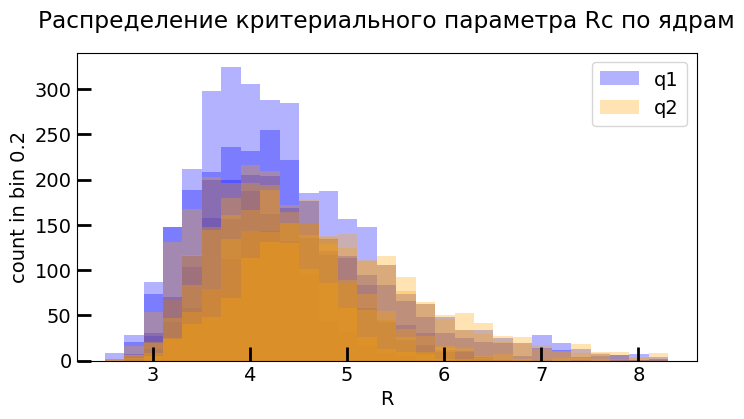

In [10]:
cl.hist_Rc(r,one=True,norm=False,step_bins=0.2,save=True)

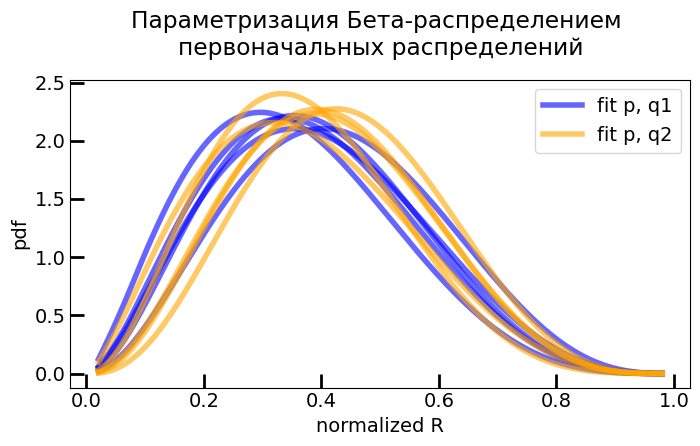

In [11]:
cl.plot_norm(0,0,save=True,appro=False,fit=True,data=False)

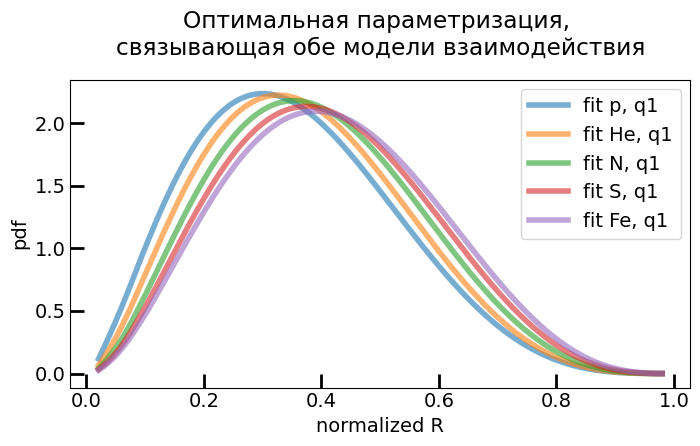

In [12]:
cl.plot_norm(0,0,save=True,appro=True,fit=False,data=False)

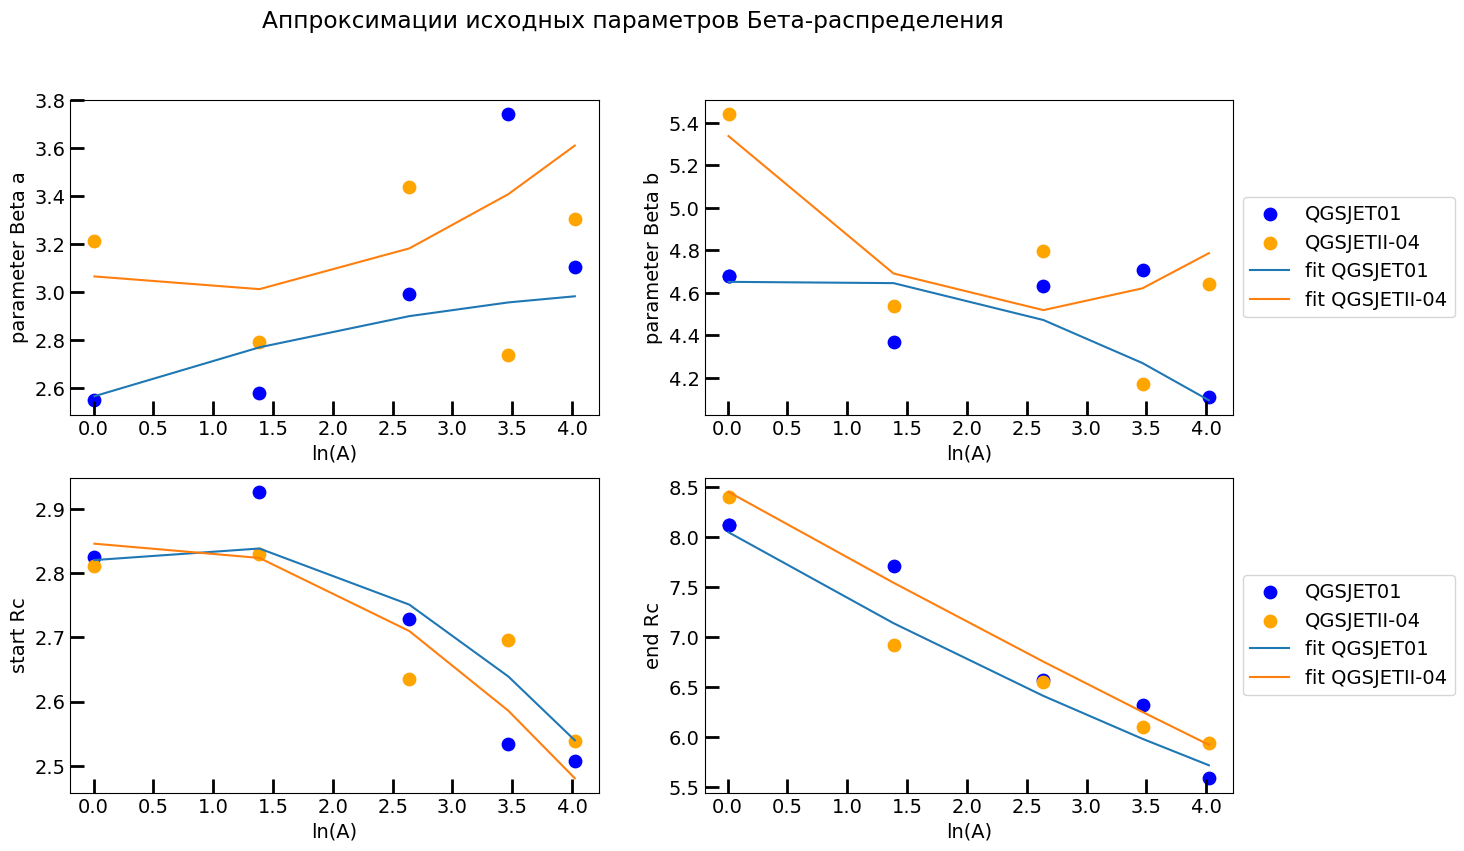

In [13]:
cl.plot_appro_common(save=True)

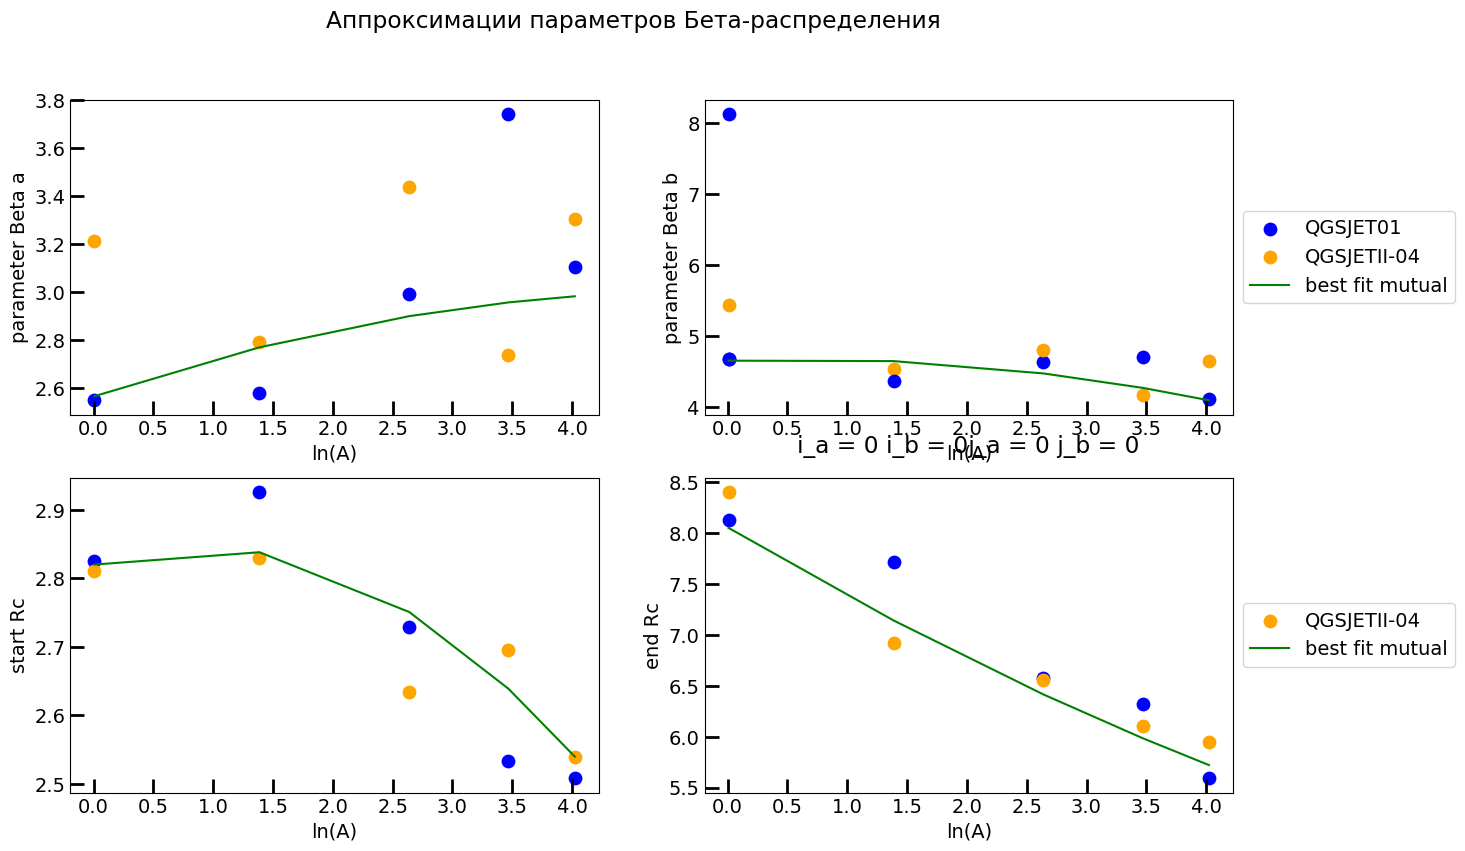

In [14]:
cl.plot_best_appro(0,0,0,0,save=True)

Search mass distribution
Processing...  0 / 10 p, q1
Processing...  1 / 10 He, q1
Processing...  2 / 10 N, q1
Processing...  3 / 10 S, q1
Processing...  4 / 10 Fe, q1
Processing...  5 / 10 p, q2
Processing...  6 / 10 He, q2
Processing...  7 / 10 N, q2
Processing...  8 / 10 S, q2
Processing...  9 / 10 Fe, q2
i_a=  0 ; i_b=  0 ; j_a=  0 ; j_b=  0 ; error=  5.02


(0,
 0,
 0,
 0,
 5.017325201513396,
 array([60.99902894, 45.99237697, 10.32478818,  2.10356476, 19.42070625,
        15.81382458, 36.90565956, 20.2285359 ,  2.5574185 , -0.48970363]))

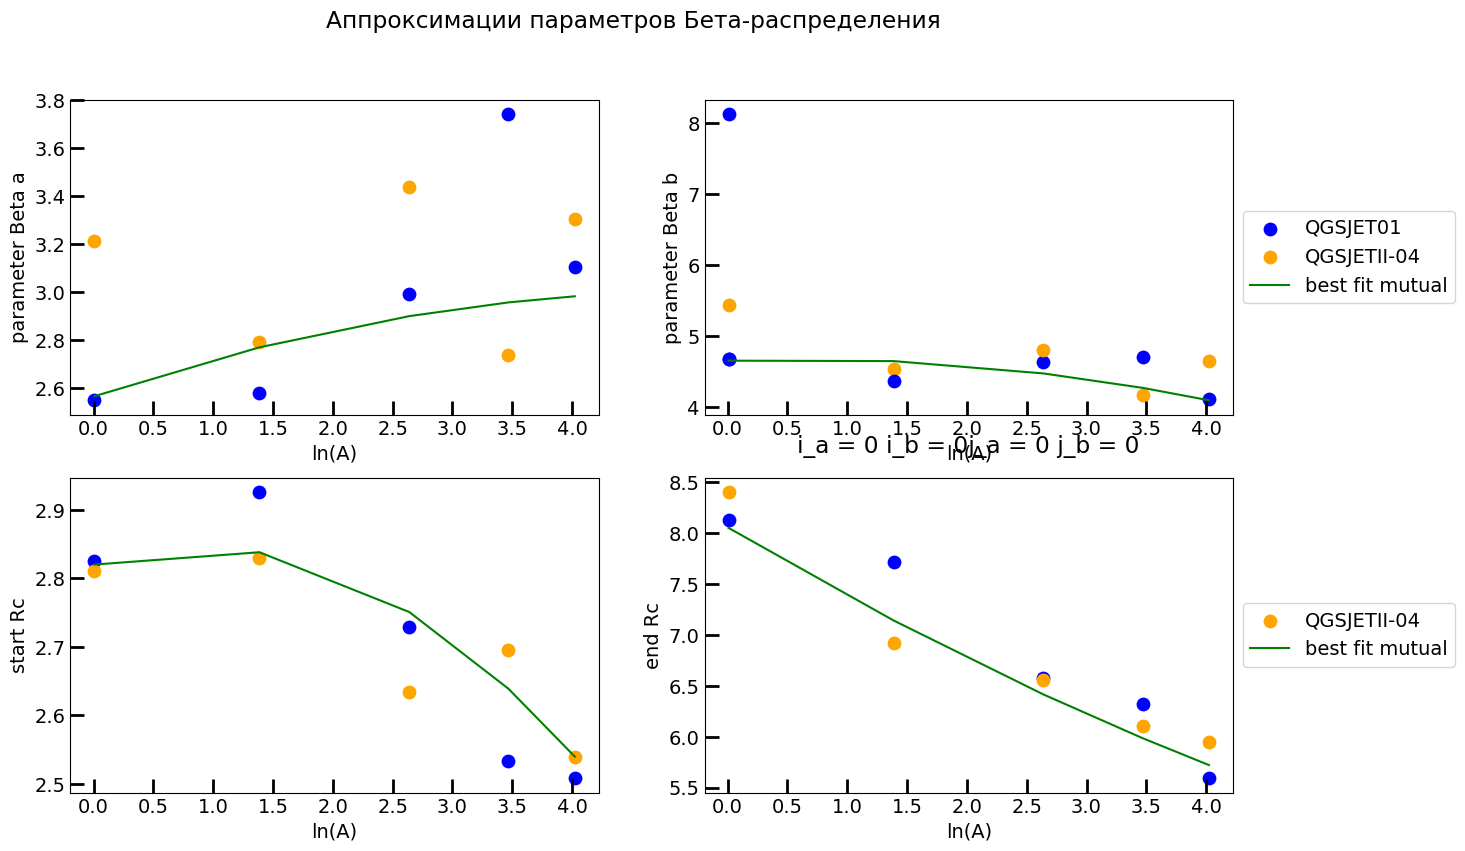

In [311]:
if optimization=='on': cl.optim_fix_border(0,0,0,0)

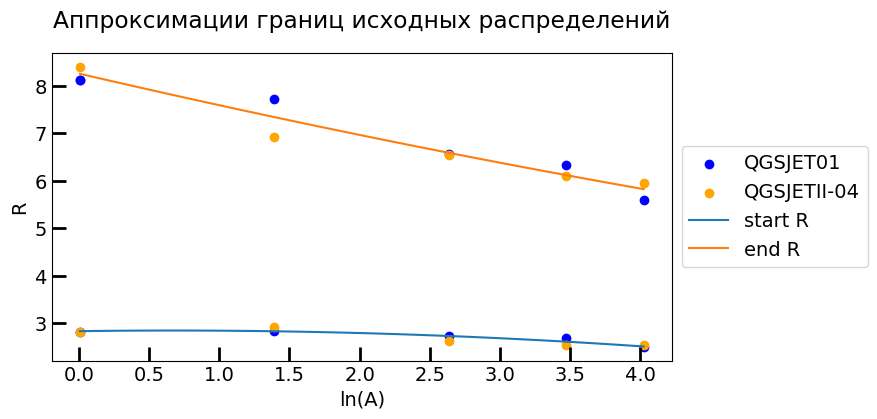

In [15]:
cl.fit_border_graph()

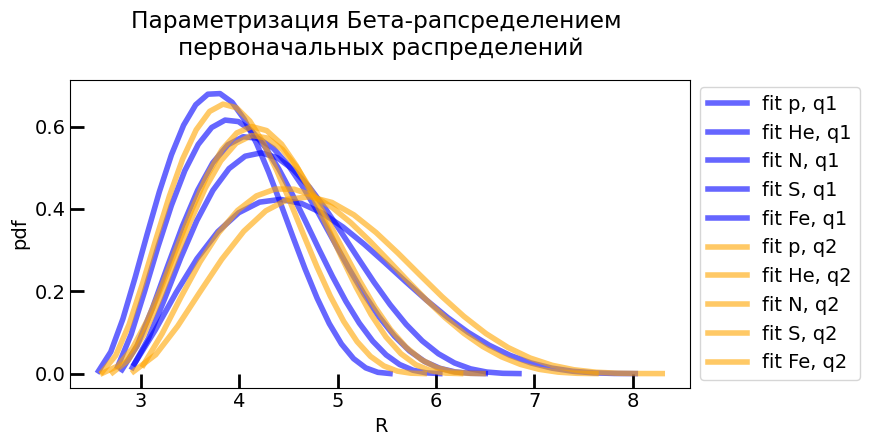

In [16]:
cl.plot(i_a=0,i_b=0,save=True,appro=False,fit=True)

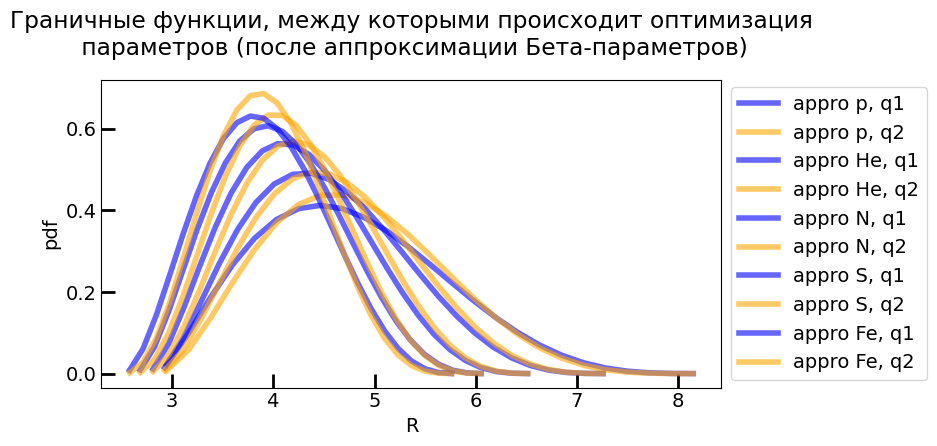

In [17]:
cl.plot(i_a=0,i_b=0,save=True,appro=True)

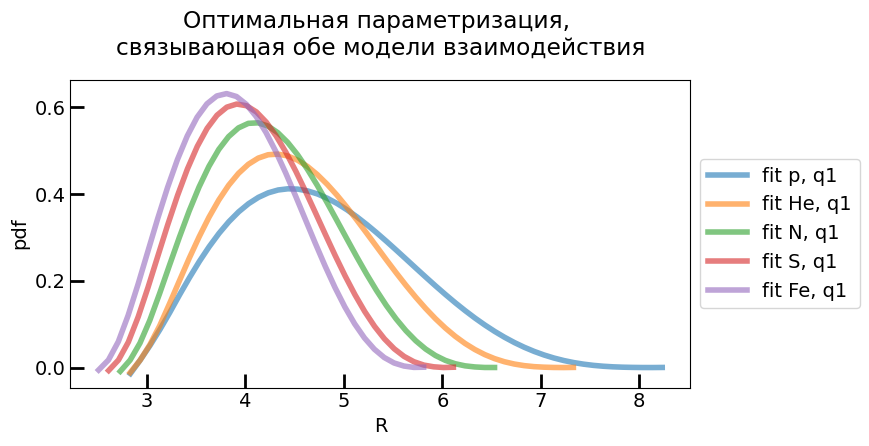

In [18]:
cl.plot(i_a=0,i_b=0,save=True,optim=True,appro=False,fit=False)

# Оптимизация параметров Бета-распределения
Поиск таких параметров, которые дают наименьшее отклонение средней массы от истинной.

# Массовое распределение с известными оптимальными аппркосимациями Бета-параметров  (i_a, i_b, j_a, j_b)

In [19]:
cl=find_A(r,omega_beta=3,omega_border=3)
R_to_A=cl.from_R_to_A(r,0,0,0,0)
R_to_A['real_A']=0
for typ in range(N_samples):
    R_to_A['real_A'][R_to_A['type_part']==m_name[typ]]=mass_true[typ]
print('fcn = ', round(fcn(R_to_A)))

Search mass distribution
Processing... 0/10  p, q1
Processing... 1/10  He, q1
Processing... 2/10  N, q1
Processing... 3/10  S, q1
Processing... 4/10  Fe, q1
Processing... 5/10  p, q2
Processing... 6/10  He, q2
Processing... 7/10  N, q2
Processing... 8/10  S, q2
Processing... 9/10  Fe, q2
fcn =  210


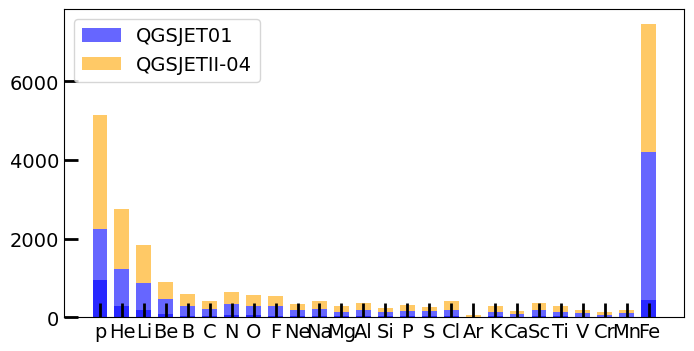

In [20]:
cl.mass_distribution(R_to_A,r)

In [21]:
plt.rcParams['figure.figsize']=(5,4)
class chek_deviations_true_mass_from_estimate:
    def __init__(self,R_to_A,num_core=n_type,add_name=glob_add_name):
        self.add_name=add_name
        self.R_to_A=R_to_A
        self.num_core=num_core
        self.mean_A=find_mean_A(self.R_to_A)
        self.p0,self.p1,self.p2=appro_square(np.array(self.mean_A),(m_sort-np.array(self.mean_A)),print_error=True)
        self.add_to_mean_mass=self.p0+self.p1*np.array(self.mean_A)+self.p2*(np.array(self.mean_A))**2        
        self.est_A=np.array(self.mean_A)+self.add_to_mean_mass
        self.err_est=self.add_to_mean_mass+np.array(self.mean_A)-m_sort
        
        direct_out=Path.cwd()/'Sphere-2_result'/'graphs'/model_atmosphere/'{}PeV'.format(Energy_CR)/Angle_CR/'{}m'.format(h)/self.add_name
        os.makedirs(direct_out, exist_ok=True)
        self.direct_graphs = direct_out
        
    def estimate_mass(self):
        print('error general', sum(abs(self.add_to_mean_mass+np.array(self.mean_A)-mass_true)))
        return self.add_to_mean_mass
    
    def graph_lines(self,dots='estimate'):
        fig,ax=plt.subplots(figsize=(10,2))
        if dots=='mean':
            dot=self.mean_A
        elif dots=='estimate':
            dot=self.est_A
        for i in range(N_samples):
            # Истинные массы -- вертикальные линии
            plt.axvline(mass_true[i],color=color_two[i])
            # Рассчитанные выборочные средние или оценки масс
            if i==0:
                plt.scatter(np.array(dot)[i],[1],color=color_two[i],alpha=0.9,s=80,label='QGSJET01')
            if i==self.num_core:
                plt.scatter(np.array(dot)[i],[1],color=color_two[i],alpha=0.9,s=80,label='QGSJETII-04') 
            else: 
                plt.scatter(np.array(dot)[i],[1],color=color_two[i],alpha=0.9,s=80)
        plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
        plt.xlabel('A')
        plt.tick_params(left=False,  labelleft=False)
        plt.savefig(self.direct_graphs/Path(dots+'_A.png'),bbox_inches='tight')  
    
    def graph_depend(self,style='mean_true'):
        fig,ax=plt.subplots()
        if style=='mean_true':
            number_style='_0_'
            x=np.array(self.mean_A)
            y=m_sort
            xlabel='<M>'
            ylabel=r'$A_{true}$'
        elif style=='appro_true-mean':
            number_style='_1_'
            x=np.array(self.mean_A)
            y=m_sort-np.array(self.mean_A)
            xlabel='<M>'
            ylabel=r'$A_{true}$ — <M>'
            # Аппроксимация разности между истинной массой и выборочным средним 
            # в зависимости от выборочного среднего 
            df_y=pd.DataFrame({'mean_A':self.mean_A,'y':self.add_to_mean_mass})
            df_y=df_y.sort_values(by=['mean_A'])
            plt.plot(df_y['mean_A'].to_numpy(),df_y['y'],color='green',label='fit')            
        elif style=='est_true':
            number_style='_2_'
            x=m_sort
            y=self.est_A
            xlabel=r'$A_{true}$'
            ylabel=r'$A_{est}$'           
            # Диагональ
            xx=np.linspace(0,60,100)
            yy=xx
            plt.plot(xx,yy,color='black')
        elif style=='error_est':
            number_style='_3_'
            x=m_sort
            y=self.err_est
            xlabel=r'$A_{true}$'
            ylabel='error, a.m.u.'           
#         try:     
        for i in range(N_samples):
            if i==0:
                plt.scatter(x[i],y[i],color=color_sort[i],s=80,label='QGSJET01')
            if i==self.num_core:
                plt.scatter(x[i],y[i],color=color_sort[i],s=80,label='QGSJETII-04')
            else:
                plt.scatter(x[i],y[i],color=color_sort[i],s=80)
        plt.legend()
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

        plt.savefig(self.direct_graphs/Path('7'+number_style+style+'_A.png'),bbox_inches='tight')
#         except:
#         print('Choose one of the style graphs: "mean_true","appro_true-mean","est_true","error_est".')

In [22]:
chek=chek_deviations_true_mass_from_estimate(R_to_A)

error 367.97427085644694


In [238]:
# chek.graph_lines('mean')

In [239]:
# chek.graph_lines()

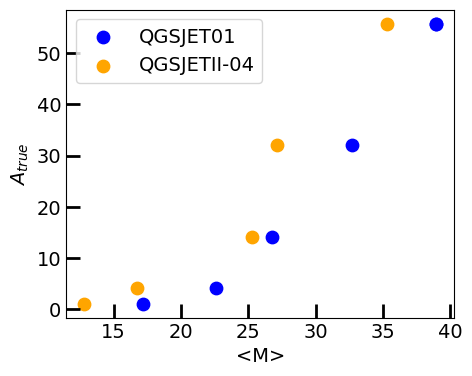

In [23]:
chek.graph_depend()

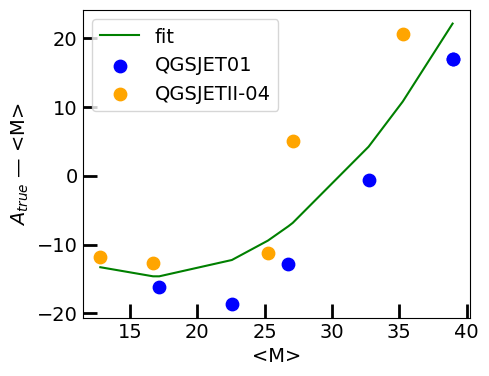

In [24]:
chek.graph_depend('appro_true-mean')

Please, choose one of the style graphs: "mean_true","appro_true-mean","est_true","error_est".


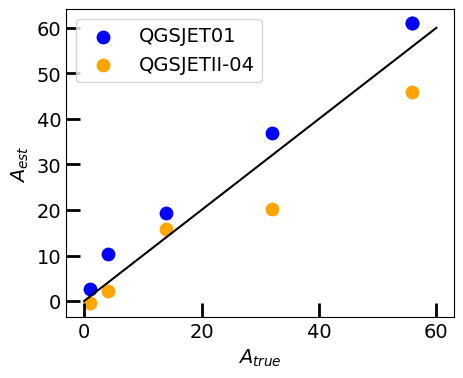

In [270]:
chek.graph_depend('est_true')

In [271]:
# chek.graph_depend('error_est')

# Оценка средней массы по смешанной выборке

## Цикл для множества разных выборок

In [261]:
class estimate_average_mass:
    def __init__(self,num_core=n_type,add_name=glob_add_name):
        self.add_name=add_name
        self.num_core=num_core
        self.N_samples_mix=n_type*2
        
        direct_out=Path.cwd()/'Sphere-2_result'/'graphs'/model_atmosphere/'{}PeV'.format(Energy_CR)/Angle_CR/'{}m'.format(h)/self.add_name
        os.makedirs(direct_out, exist_ok=True)
        self.direct_graphs = direct_out
        
    def extract_data(self,probability):
        df_data_list=[]
        rhomax = 170  # мм -- радиус, в котором находится пик ФПР
        for i in range(n_type*2):
            Type_particle_CR=Type_particles_CR[i-n_type]   
            if i<n_type:  model_interaction='q1'
            else:         model_interaction='q2'

            direct_in=Path.cwd()/'Sphere-2_result'/'appro_param_with_bg'/model_atmosphere/model_interaction/'{}PeV'.format(Energy_CR)/Angle_CR/'{}m'.format(h)
            file_in=direct_in/Path('param_bg_'+
                '{}_{}_{}PeV_{}_{}m_{}.txt'.format(model_atmosphere,model_interaction,Energy_CR,Angle_CR,h,Type_particle_CR))

            p = ((((pd.read_csv(file_in,header=0,sep=',')).dropna()).iloc[:,1:]))
            # Ограничение на радиус, в котором находится пик ФПР и отброс событий с неудавшейся аппроксимацией
            p2 = p[ ((p['x0']**2+p['y0']**2)**(1./2)<rhomax) & (p['fcn']<10000) ]
            mask=np.random.choice(a=[True, False], size=(len(p2['p0'])), p=[probability[i], 1-probability[i]])
            p2n=p2[mask]
#             print('Number of event ', Type_particle_CR, len(p2n['p1']))
            p2n.index = np.arange(len(p2n['p0']))

            df_data_list.append(p2n)

        key=[j for j in range(n_type*2)]
        df_together = pd.concat(df_data_list,keys=key)

        return df_together
    
    def find_Rc(self,df):
        aver,cri,aver2,cri2=criterion(df,r1,r2,r3)
        r_mix=(np.asarray(cri,dtype='object')**2+np.asarray(cri2,dtype='object')**2)**(1./2)
        return r_mix    

    def find_aver_A(self,R_to_A_mix):
        Ni=np.zeros(26)
        for i in range(26):
            Ni[i]=np.count_nonzero(R_to_A_mix['A'][(R_to_A_mix['A']<(mass_toFe[i]+0.1))&(R_to_A_mix['A']>(mass_toFe[i]-0.1))])
        m_aver=sum(mass_toFe*Ni)/sum(Ni)

        Nri=np.zeros(self.N_samples_mix)
        for i in range(self.N_samples_mix):
            Nri[i]=np.count_nonzero(R_to_A_mix['type_part'][R_to_A_mix['type_part']==m_name[i]])
#         print(mass_true,Nri,np.count_nonzero(R_to_A_mix['A']))
        A_aver_real=sum(mass_true*Nri)/sum(Nri)
        return m_aver,A_aver_real,Ni,Nri  
    
    def f_line(self,p0,p1,x):
        return p0+p1*x  
    
    # Аппроксимация разности между выборочным средним и истинной средней массой 
    # в зависимости от выборочного среднего и её аппроксимация
    def find_A_est(self,df_mass_result):
            p0_est,p1_est=appro_lineal(np.array(df_mass_result['mass_mean']),np.array(df_mass_result['mass_mean']-
                                                                                     df_mass_result['A_aver_true']))            
            A_est=df_mass_result['mass_mean']-(p0_est+p1_est*df_mass_result['mass_mean'])
            return A_est,p0_est,p1_est
        
    def graph_aver_A(self,df_mass_result,style='mean_aver_true'):
        fig,ax=plt.subplots()
        if style=='mean_aver_true':
            number_style='_0_'
            x=df_mass_result['A_aver_true']
            y=df_mass_result['mass_mean']
            xlabel=r'$\overline{A}_{true}$'
            ylabel=r'$\overline{M}$'
            col='royalblue'
        elif style=='appro_aver_true-mean':
            number_style='_1_'
            x=df_mass_result['mass_mean']
            y=df_mass_result['mass_mean']-df_mass_result['A_aver_true']
            xlabel=r'$\overline{M}$'
            ylabel=r'$\overline{M}-\overline{A}_{true}$'
            col='royalblue'
            # Аппроксимация разности между выборочным средним и истинной средней массой 
            # в зависимости от выборочного среднего и её аппроксимация
            A_est,p0_est,p1_est=self.find_A_est(df_mass_result)
            x_many=np.arange(df_mass_result['mass_mean'].min(),df_mass_result['mass_mean'].max())
            err_A=sum(abs(A_est-df_mass_result['A_aver_true']))
            print(err_A)
            plt.plot(x_many,self.f_line(p0_est,p1_est,x_many),label='fit',color=col)
            plt.legend()      
        elif style=='est_aver_true':
            number_style='_2_'
            A_est,p0_est,p1_est=self.find_A_est(df_mass_result)
            df_A_out=pd.DataFrame({'A_est':A_est,'A_true':df_mass_result['A_aver_true']})
            MAE=sum(abs(df_A_out['A_est']-df_A_out['A_true']))/len(df_A_out['A_est'])
            print(MAE)            
            
            x=df_mass_result['A_aver_true']
            y=A_est
            xlabel=r'$\overline{A}_{true}$' # Истинные средние массы
            ylabel=r'$\overline{A}_{est}$'  # Оцененные средние массы      
            col='green'
            # Диагональ
            xx=np.linspace(min(df_A_out['A_true']),max(df_A_out['A_true']),100)
            yy=xx
            plt.plot(xx,yy,color='green')        
            plt.text(4,43.2,'MAE = '+str(round(MAE,2))+' amu')
                
        try:     
            plt.scatter(x,y,s=80,color=col)

            plt.grid()
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            
            plt.savefig(self.direct_graphs/Path('8'+number_style+style+'_A.png'),bbox_inches='tight')
        except:
            print('Choose one of the style graphs: "mean_aver_true","appro_aver_true-mean","est_aver_true","error_est".')        

In [262]:
aver_mass_mix=estimate_average_mass()

# Создание вероятностей

In [ ]:
prob_all=[]
N_all=70
for i in range(N_all):
    prob_loc=[np.random.random()*((N_all-i)/N_all)*0.8,np.random.random()*((N_all-i)/N_all)*0.4,np.random.random()*((N_all-i)/N_all)*0.2,
             np.random.random()*(i/N_all)*0.4,np.random.random()*(i/N_all),
              np.random.random()*((N_all-i)/N_all)*0.8,np.random.random()*((N_all-i)/N_all)*0.4,np.random.random()*((N_all-i)/N_all)*0.2,
             np.random.random()*(i/N_all)*0.4,np.random.random()*(i/N_all)]
    prob_all.append(prob_loc)
prob_all=np.array(prob_all)
prob_all[prob_all<0.006]=0.006
prob_all[prob_all>0.993]=0.993

In [119]:
best_ia,best_ib,best_ja,best_jb

(0, 0, 0, 0)

In [143]:
if result_average_mass=='on':
    df_mass_result=pd.DataFrame(index=np.arange(len(prob_all)),columns=['mass_mean','A_aver_true','Ni','Nri'])
    aver_mass_mix=estimate_average_mass()
    for i in range(len(prob_all)):
        print('# = {}/{}'.format(i,N_all))
        df_mix=aver_mass_mix.extract_data(probability=prob_all[i])
        Rc_mix=aver_mass_mix.find_Rc(df_mix)
        R_to_A_mix=cl.from_R_to_A(Rc_mix, i_a=best_i_a, i_b=best_i_b, j_a=best_j_a, j_b=best_j_b)

        mass_mean,A_aver_true,Ni,Nri=aver_mass_mix.find_aver_A(R_to_A_mix)
        df_mass_result.loc[i]=mass_mean,A_aver_true,Ni,Nri

# = 0/70
Number of event  p 1162
Number of event  He 496
Number of event  N 135
Number of event  S 11
Number of event  Fe 7
Number of event  p 568
Number of event  He 327
Number of event  N 138
Number of event  S 9
Number of event  Fe 6
N_samples  10
Search mass distribution
Processing... 0/10  p, q1
Processing... 1/10  He, q1
Processing... 2/10  N, q1
Processing... 3/10  S, q1
Processing... 4/10  Fe, q1
Processing... 5/10  p, q2
Processing... 6/10  He, q2
Processing... 7/10  N, q2
Processing... 8/10  S, q2
Processing... 9/10  Fe, q2
[ 1.0078  4.0026 14.0067 32.064  55.847   1.0078  4.0026 14.0067 32.064
 55.847 ] [1162.  496.  135.   11.    7.  568.  327.  138.    9.    6.] 200000
18.112162028681357 3.577738335082197 [1007.  349.  199.  100.   63.   50.   67.   52.   46.   34.   43.   29.
   28.   27.   29.   24.   43.    4.   23.    8.   30.   26.   23.   11.
   20.  524.] [1162.  496.  135.   11.    7.  568.  327.  138.    9.    6.]
# = 1/70
Number of event  p 1301
Number of event  

Search mass distribution
Processing... 0/10  p, q1
Processing... 1/10  He, q1
Processing... 2/10  N, q1
Processing... 3/10  S, q1
Processing... 4/10  Fe, q1
Processing... 5/10  p, q2
Processing... 6/10  He, q2
Processing... 7/10  N, q2
Processing... 8/10  S, q2
Processing... 9/10  Fe, q2
[ 1.0078  4.0026 14.0067 32.064  55.847   1.0078  4.0026 14.0067 32.064
 55.847 ] [763. 214. 252.  16.  92. 362.  74.  25.  11.  26.] 200000
19.872183814713896 7.4234625068119895 [548. 224. 143.  76.  37.  32.  47.  39.  36.  33.  28.  19.  19.  16.
  12.  14.  37.   6.  18.   8.  11.  10.  11.   5.   8. 398.] [763. 214. 252.  16.  92. 362.  74.  25.  11.  26.]
# = 10/70
Number of event  p 1133
Number of event  He 477
Number of event  N 141
Number of event  S 151
Number of event  Fe 223
Number of event  p 84
Number of event  He 111
Number of event  N 112
Number of event  S 7
Number of event  Fe 70
N_samples  10
Search mass distribution
Processing... 0/10  p, q1
Processing... 1/10  He, q1
Processing... 

Processing... 1/10  He, q1
Processing... 2/10  N, q1
Processing... 3/10  S, q1
Processing... 4/10  Fe, q1
Processing... 5/10  p, q2
Processing... 6/10  He, q2
Processing... 7/10  N, q2
Processing... 8/10  S, q2
Processing... 9/10  Fe, q2
[ 1.0078  4.0026 14.0067 32.064  55.847   1.0078  4.0026 14.0067 32.064
 55.847 ] [977.  76. 210.  97. 334. 721. 219.  12.  15. 151.] 200000
21.259454324324327 13.04354971550498 [868. 312. 198.  92.  57.  42.  58.  56.  46.  35.  42.  24.  37.  24.
  30.  29.  39.   3.  32.  11.  28.  25.  14.  10.  10. 690.] [977.  76. 210.  97. 334. 721. 219.  12.  15. 151.]
# = 19/70
Number of event  p 302
Number of event  He 56
Number of event  N 126
Number of event  S 211
Number of event  Fe 38
Number of event  p 527
Number of event  He 254
Number of event  N 42
Number of event  S 126
Number of event  Fe 328
N_samples  10
Search mass distribution
Processing... 0/10  p, q1
Processing... 1/10  He, q1
Processing... 2/10  N, q1
Processing... 3/10  S, q1
Processing... 

Processing... 3/10  S, q1
Processing... 4/10  Fe, q1
Processing... 5/10  p, q2
Processing... 6/10  He, q2
Processing... 7/10  N, q2
Processing... 8/10  S, q2
Processing... 9/10  Fe, q2
[ 1.0078  4.0026 14.0067 32.064  55.847   1.0078  4.0026 14.0067 32.064
 55.847 ] [194.  43. 124.  59. 314. 749. 308.  35.  40. 528.] 200000
24.508506892230578 22.882140058479532 [587. 252. 149.  85.  58.  34.  54.  48.  55.  31.  30.  32.  25.  32.
  25.  24.  46.   1.  22.  13.  38.  23.  22.  12.  16. 680.] [194.  43. 124.  59. 314. 749. 308.  35.  40. 528.]
# = 28/70
Number of event  p 680
Number of event  He 296
Number of event  N 163
Number of event  S 344
Number of event  Fe 32
Number of event  p 564
Number of event  He 418
Number of event  N 7
Number of event  S 91
Number of event  Fe 421
N_samples  10
Search mass distribution
Processing... 0/10  p, q1
Processing... 1/10  He, q1
Processing... 2/10  N, q1
Processing... 3/10  S, q1
Processing... 4/10  Fe, q1
Processing... 5/10  p, q2
Processing... 

Processing... 3/10  S, q1
Processing... 4/10  Fe, q1
Processing... 5/10  p, q2
Processing... 6/10  He, q2
Processing... 7/10  N, q2
Processing... 8/10  S, q2
Processing... 9/10  Fe, q2
[ 1.0078  4.0026 14.0067 32.064  55.847   1.0078  4.0026 14.0067 32.064
 55.847 ] [385.  97.  59. 117. 602. 111. 131.  27. 224. 207.] 200000
28.023144581632653 29.964839183673472 [353. 188. 138.  61.  44.  28.  52.  47.  44.  23.  29.  27.  32.  19.
  25.  21.  25.   1.  24.  11.  32.  20.  20.   7.  13. 676.] [385.  97.  59. 117. 602. 111. 131.  27. 224. 207.]
# = 37/70
Number of event  p 619
Number of event  He 80
Number of event  N 85
Number of event  S 119
Number of event  Fe 817
Number of event  p 462
Number of event  He 198
Number of event  N 61
Number of event  S 10
Number of event  Fe 396
N_samples  10
Search mass distribution
Processing... 0/10  p, q1
Processing... 1/10  He, q1
Processing... 2/10  N, q1
Processing... 3/10  S, q1
Processing... 4/10  Fe, q1
Processing... 5/10  p, q2
Processing... 

Processing... 4/10  Fe, q1
Processing... 5/10  p, q2
Processing... 6/10  He, q2
Processing... 7/10  N, q2
Processing... 8/10  S, q2
Processing... 9/10  Fe, q2
[ 1.0078  4.0026 14.0067 32.064  55.847   1.0078  4.0026 14.0067 32.064
 55.847 ] [462. 255.  15. 139. 801. 470.  18.  59.  52. 296.] 200000
27.199191063498247 27.447159407869105 [525. 216. 177.  90.  62.  48.  65.  48.  50.  36.  42.  26.  43.  28.
  36.  25.  43.   5.  26.  11.  33.  29.  16.  15.  22. 850.] [462. 255.  15. 139. 801. 470.  18.  59.  52. 296.]
# = 46/70
Number of event  p 130
Number of event  He 279
Number of event  N 38
Number of event  S 487
Number of event  Fe 321
Number of event  p 138
Number of event  He 209
Number of event  N 15
Number of event  S 422
Number of event  Fe 551
N_samples  10
Search mass distribution
Processing... 0/10  p, q1
Processing... 1/10  He, q1
Processing... 2/10  N, q1
Processing... 3/10  S, q1
Processing... 4/10  Fe, q1
Processing... 5/10  p, q2
Processing... 6/10  He, q2
Processing.

Processing... 4/10  Fe, q1
Processing... 5/10  p, q2
Processing... 6/10  He, q2
Processing... 7/10  N, q2
Processing... 8/10  S, q2
Processing... 9/10  Fe, q2
[ 1.0078  4.0026 14.0067 32.064  55.847   1.0078  4.0026 14.0067 32.064
 55.847 ] [178. 139.  27. 513. 935. 245. 142.  40.  50. 770.] 200000
31.373021612372487 38.09168999670944 [ 432.  247.  190.  101.   80.   35.   72.   58.   63.   39.   43.   41.
   46.   35.   40.   38.   49.    7.   29.   18.   45.   25.   25.   14.
   34. 1233.] [178. 139.  27. 513. 935. 245. 142.  40.  50. 770.]
# = 55/70
Number of event  p 13
Number of event  He 23
Number of event  N 44
Number of event  S 552
Number of event  Fe 1039
Number of event  p 230
Number of event  He 140
Number of event  N 66
Number of event  S 219
Number of event  Fe 549
N_samples  10
Search mass distribution
Processing... 0/10  p, q1
Processing... 1/10  He, q1
Processing... 2/10  N, q1
Processing... 3/10  S, q1
Processing... 4/10  Fe, q1
Processing... 5/10  p, q2
Processing...

Search mass distribution
Processing... 0/10  p, q1
Processing... 1/10  He, q1
Processing... 2/10  N, q1
Processing... 3/10  S, q1
Processing... 4/10  Fe, q1
Processing... 5/10  p, q2
Processing... 6/10  He, q2
Processing... 7/10  N, q2
Processing... 8/10  S, q2
Processing... 9/10  Fe, q2
[ 1.0078  4.0026 14.0067 32.064  55.847   1.0078  4.0026 14.0067 32.064
 55.847 ] [ 115.   32.   30.  559.  388.   92.   48.   10.   67. 1393.] 200000
32.412202838332114 44.12021272860278 [ 273.  246.  165.   87.   81.   35.   69.   73.   65.   43.   45.   37.
   41.   30.   40.   31.   49.    7.   34.   17.   49.   34.   14.   14.
   25. 1130.] [ 115.   32.   30.  559.  388.   92.   48.   10.   67. 1393.]
# = 64/70
Number of event  p 95
Number of event  He 52
Number of event  N 11
Number of event  S 750
Number of event  Fe 247
Number of event  p 17
Number of event  He 6
Number of event  N 9
Number of event  S 215
Number of event  Fe 1134
N_samples  10
Search mass distribution
Processing... 0/10  p, q1

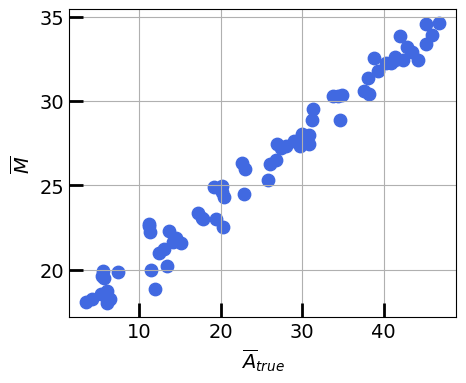

In [263]:
if result_average_mass=='on': aver_mass_mix.graph_aver_A(df_mass_result)

109.04844631141441


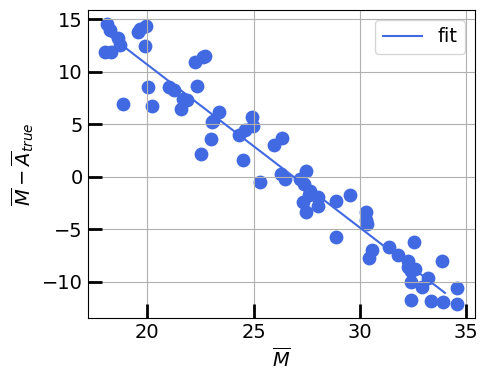

In [264]:
if result_average_mass=='on': aver_mass_mix.graph_aver_A(df_mass_result,style='appro_aver_true-mean')

1.55783494730592


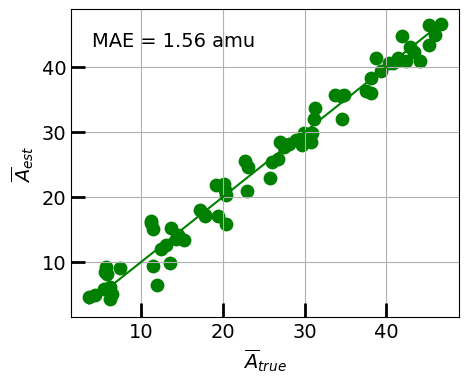

In [265]:
if result_average_mass=='on': aver_mass_mix.graph_aver_A(df_mass_result,style='est_aver_true')